### <img src="https://www.dropbox.com/s/l93ecugg1jbtjiw/fga.png?raw=1" width="1200" height="400">

<ul>
    <li> <b>Campus UnB Gama</b> </li>
    <li> <b>Disciplina: Processamento Digital de Sinais Financeiros</b></li> 
    <li>
     Prof. Marcelino Monteiro de Andrade Dr.</li>
</ul> 
    
    Segunda (2/3) Atividade Prática Avaliativa - Algo Trading
    Entrega da Atividade 31/08/2022 
    "A não entrega na data esperada reduz em 50% na nota da avaliação"


<div id="Tópicos">
<h2>Questões</h2>
&ensp;
    <ol> 
        <li>Implemente uma estratégia de trade automático baseado em duas médias móveis. Utilize um período mínimo de 3 anos, otimize nos dois primeiros anos e aplique no terceiro. Aproveite os ativos escolhidos na primeira avaliação, considere um capital de R$\100.000,00 e as taxas envolvidas na operação.</a></li>&ensp;
        <li>Implemente uma estratégia de trade automático baseado em duas médias móveis anteriores, adicionando à aplicação o RSI ou MACD. Utilize um período mínimo de 3 anos, otimize nos dois primeiros anos e aplique no terceiro. Aproveite os ativos escolhidos na questão 1.</a></li>&ensp;
        <li>Escolha uma estratégia de trade automático de contra tendência, apresentada na Referência Palex. Utilize um período mínimo de 3 anos, otimize nos dois primeiros anos e aplique no terceiro. Aplique nos ativos escolhidos na questão 1.</a></li>&ensp;
        <li>Compare os resultados das três estratégias de trades, quanto: a) Retorno de Capital, b) Número de Trades, c) Taxa de Acertos, d) Fator de Lucro, e) Índice Sharpe e o f) retorno dos ativos avaliados na condição buy&hold e com relação ao índice bovespa.</a></li>&ensp;
        <li>Observação: caso a equipe tenha o interesse em avaliar outras estratégias de algo trading e bem vindo também!</a></li>&ensp;        
</ol>
</div>



In [101]:
%pip install yfinance
%pip install --upgrade matplotlib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [102]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import math 

In [103]:
plt.rcParams['figure.figsize'] = [20,10]
plt.rcParams['figure.dpi'] = 100

In [104]:
data = yf.download(' BTC-USD','2016-01-01','2020-10-01')
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-01-01,430.721008,436.246002,427.515015,434.334015,434.334015,36278900
2016-01-02,434.622009,436.062012,431.869995,433.437988,433.437988,30096600
2016-01-03,433.578003,433.743011,424.705994,430.010986,430.010986,39633800
2016-01-04,430.061005,434.516998,429.084015,433.091003,433.091003,38477500
2016-01-05,433.069000,434.182007,429.675995,431.959991,431.959991,34522600
...,...,...,...,...,...,...
2020-09-27,10746.892578,10803.976562,10622.921875,10775.269531,10775.269531,53745972818
2020-09-28,10776.613281,10945.347656,10703.893555,10709.652344,10709.652344,47762394731
2020-09-29,10709.650391,10860.000977,10649.495117,10844.640625,10844.640625,46582396602


In [128]:
def crossover_sinal(data):
    #criando sinais de compra e venda.SMA15 = MEDIA MOVEL DE 15 PERIODOS.SMA50 = MEDIA MOVEL DE 50 PERIODOS
    data['SMA15'] = data['Close'].rolling(15).mean()
    data['SMA50'] = data['Close'].rolling(50).mean()

    #diferenca periodo anterior e periodo atual
    data['Anter'] = data['SMA15'].shift(1) - data['SMA50'].shift(1)
    data['Atual'] = data['SMA15'] - data['SMA50']

    #se a anterior for negativa e a atual for positiva e um sinal de compra caso contrario e venda
    data.loc[(data['Anter']<0)&(data['Atual']>0),'Compra'] = data['Close']
    data.loc[(data['Anter']>0)&(data['Atual']<0),'Venda'] = data['Close']

    columns = ['Close','SMA15','SMA50','Compra','Venda']
    
    return data[columns]


In [106]:
output_df = crossover_sinal(data)
output_df.tail()


,Close,SMA15,SMA50,Compra,Venda
Date,,,,,
2020-09-27,10775.269531,10728.555143,11130.919570,NaN,NaN
2020-09-28,10709.652344,10754.281576,11111.597832,NaN,NaN
2020-09-29,10844.640625,10765.201758,11090.928418,NaN,NaN
2020-09-30,10784.491211,10764.371094,11078.407734,NaN,NaN
2020-10-01,10619.452148,10740.674219,11059.098086,NaN,NaN


In [107]:
#data set filtrado
filter_data = output_df.loc[(output_df.index < '2020-12-01') & (output_df.index < '2019-01-01')]

Text(0.5, 0, 'Data')

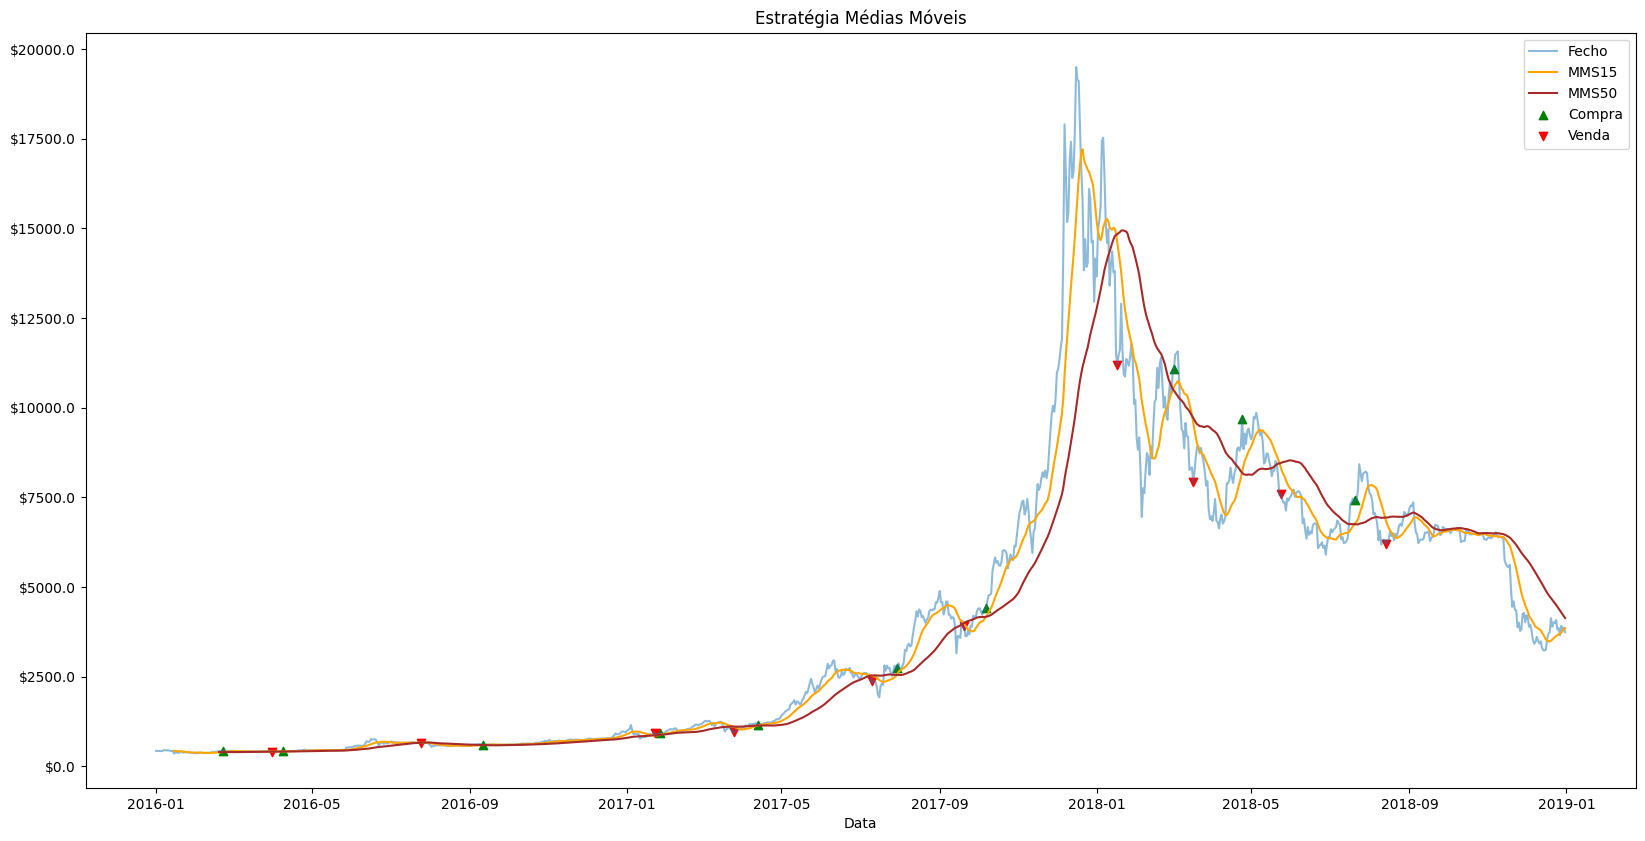

In [108]:
fig= plt.subplot()
ax = plt.subplot()

#Adiciona Informação
ax.plot(filter_data.index,filter_data['Close'],label='Fecho',alpha=0.5)
ax.plot(filter_data.index,filter_data['SMA15'],label='MMS15',color='orange')
ax.plot(filter_data.index,filter_data['SMA50'],label='MMS50',color='brown')

#Adiciona Venda e Compra
ax.scatter(filter_data.index,filter_data['Compra'],label='Compra',marker='^',color='green')
ax.scatter(filter_data.index,filter_data['Venda'],label='Venda',marker='v',color='red')

#formata

ax.legend()

#Labels adicionais
ax.yaxis.set_major_formatter('${x:}')
ax.set_title('Estratégia Médias Móveis')
ax.set_xlabel('Data')

In [109]:
#Calcular RSI
####### Compute RSI
#1º) Calcular Variação
#2º) Identificar se é um ganho ou perda
#3º) Calcular media movel (suavizada) de ganho e perda (janela definida pelo user)
#4º) Calcular RS
#5º) Calcular RSI

def indicador_RSI(df,window):
  df['change'] = df['Adj Close'] - df['Adj Close'].shift(1) #Calcular diferença entre fecho 

  df['gain'] = df.loc[df['change']>0,'change'].apply(abs) #Calcular Ganhos
  df.loc[(df['gain'].isna()),'gain']= 0 
  data[0,data.columns.get_loc('gain')] = np.NaN #df.loc[0,'gain'] = np.NaN


  df['loss'] = df.loc[df['change']<0,'change'].apply(abs) #Calcular Perdas
  df.loc[(df['loss'].isna()),'loss']= 0
  data[0,data.columns.get_loc('loss')] = np.NaN #df.loc[0,'loss'] = np.NaN

  ########### Average Gain/Loss
  #Normalmente são considerados 14 periodos (neste caso vou usar dias)
  df['avg_gain'] = df['gain'].rolling(window).mean()
  df['avg_loss'] = df['loss'].rolling(window).mean()

  #não pode ser vetorizado porque é uma formula recursiva
  first = df['avg_gain'].first_valid_index() #identificar primeiro valor que não seja nulo/na

  for index, row in df.iterrows():
    if index == first: #gravar o primeiro não nulo
      prev_avg_gain = row['avg_gain']
      prev_avg_loss = row['avg_loss']
    elif index > first: #calcular os seguintes (após o não nulo)
      df.loc[index,'avg_gain']= ((prev_avg_gain*(window -1)) + row['gain'])/window
      prev_avg_gain = df.loc[index,'avg_gain']

      df.loc[index,'avg_loss']= ((prev_avg_loss*(window -1)) + row['loss'])/window
      prev_avg_loss = df.loc[index,'avg_loss']

  #### Compute RS e RSI
  df[f'RS{window}'] = df['avg_gain']/df['avg_loss']
  df[f'RSI{window}'] = 100 - (100 / (1 + df[f'RS{window}']))

  #Filter Columns
  lista = df.columns.to_list()
  matching = [s for s in lista if "RSI" in s]
  sel_col = ['Adj Close'] + matching

  return df[sel_col].copy()

  

In [129]:
data_frame = indicador_RSI(data,14)
data_frame

,Adj Close,RSI14
Date,,
2016-01-01,434.334015,NaN
2016-01-02,433.437988,NaN
2016-01-03,430.010986,NaN
2016-01-04,433.091003,NaN
2016-01-05,431.959991,NaN
...,...,...
2020-09-27,10775.269531,50.022356
2020-09-28,10709.652344,48.683121
2020-09-29,10844.640625,51.556490


In [111]:
#se minha celula anterior for menor que setenta e minha celula posterior for maior ele entra vendido
filter_sell = (data_frame['RSI14'].shift(1)<70) & (data_frame['RSI14']>70) 
data_frame.loc[filter_sell,'Sell_Signal'] = data_frame.loc[filter_sell,'Adj Close']

In [112]:
#se minha celula anterior for maior que 30 e minha celula posterior for menor ele entra comprado
filter_buy = (data_frame['RSI14'].shift(1)>30) & (data_frame['RSI14']<30) 
data_frame.loc[filter_buy,'Buy_Signal'] = data_frame.loc[filter_buy,'Adj Close']

In [132]:
#filtra o dataframe para o periodo de 2018 a 2020
data_frame = data_frame.reset_index()
filtered_data = data_frame.loc[(data_frame['Date']<'2020-12-01')&(data_frame['Date']>'2018-12-01')]


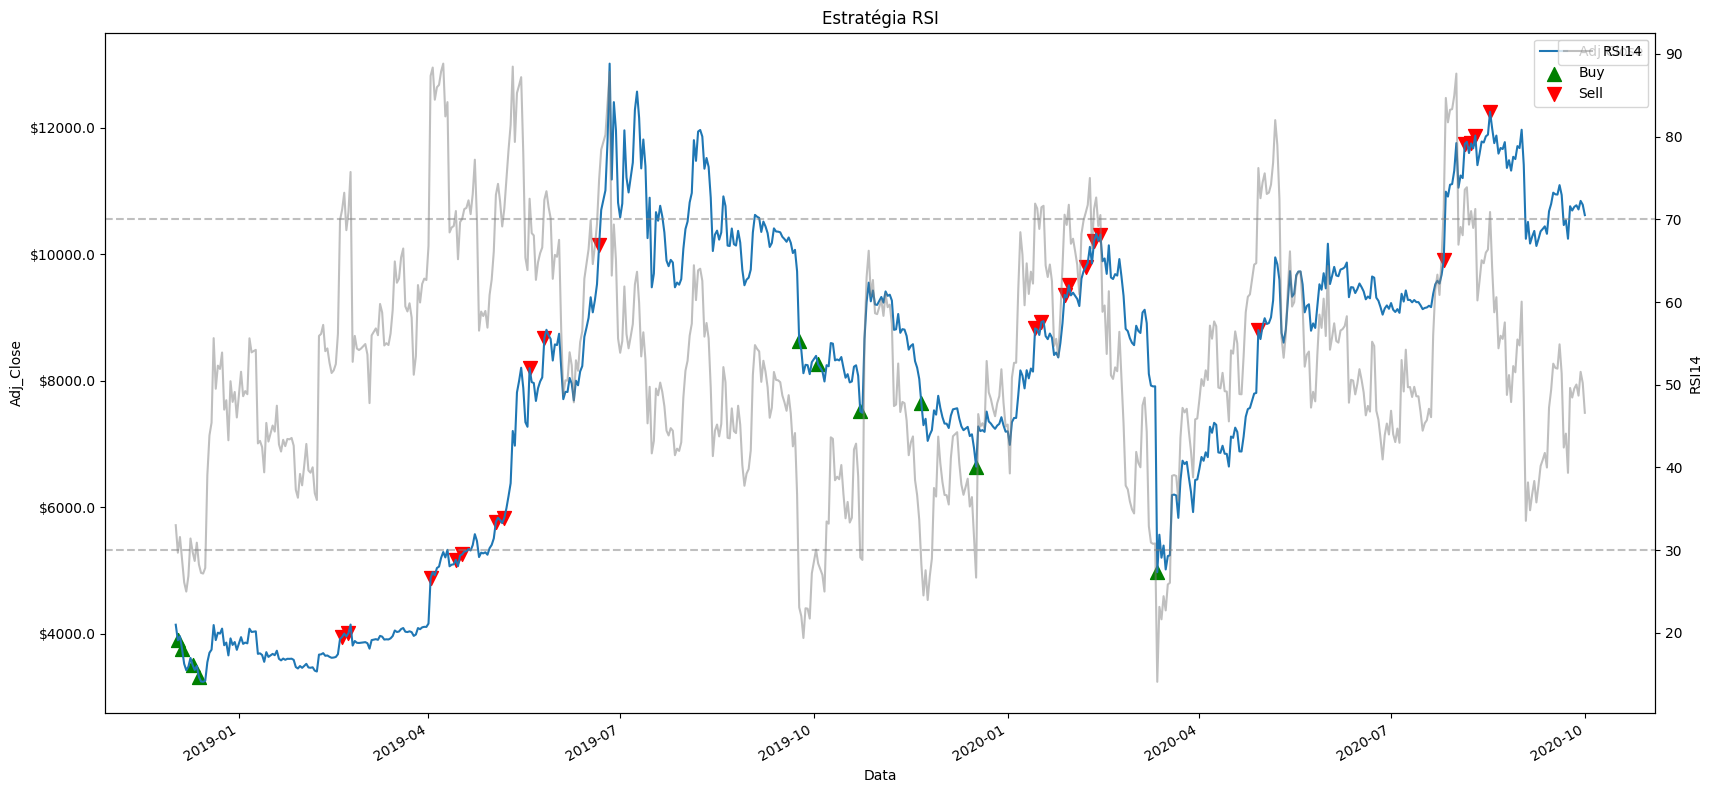

In [126]:

fig, ax = plt.subplots()

#Plot 1
ax.plot(filtered_data['Date'],filtered_data['Adj Close'],label = 'Adj Close')

#Plot 2
ax2 = ax.twinx()
ax2.plot(filtered_data['Date'],filtered_data['RSI14'],label='RSI14',color='gray',alpha=0.5)
ax2.axhline(70,color='gray',ls='--',alpha=0.5)
ax2.axhline(30,color='gray',ls='--',alpha=0.5)
ax2.set_ylabel('RSI14')
ax2.legend()

ax.scatter(filtered_data['Date'],filtered_data['Buy_Signal'],label='Buy',marker='^',color='green',s=100)
ax.scatter(filtered_data['Date'],filtered_data['Sell_Signal'],label='Sell',marker='v',color='red',s=100)

ax.yaxis.set_major_formatter('${x:}')
fig.autofmt_xdate()

ax.set_title('Estratégia RSI')
ax.set_ylabel('Adj_Close')
ax.set_xlabel('Data')
ax.legend()

